In [110]:
import collections
import math

from scipy.optimize import fsolve

from sympy import *
init_printing() # for latex output

import mpmath as mp
from mpmath import findroot
from mpmath import mpf

Global settings:

In [2]:
mp.mp.dps = 40 # decimal digits of precision in mp floats
approx = False # only use fsolve (scipy) for everything

Testing: ...

In [3]:
# Evals for N=1000, from maple and the old sage worksheet.
reference_evals = {
    'D(x*G_1_dx(x,y),y)': 1.09416749105326839436361139331519184699,
    'D_dx(x*G_1_dx(x,y),y)': 3.58480499936306184450275887839568999541,
    'D_dx_dx(x*G_1_dx(x,y),y)': 3844.44528283854975380346115822251416046,
    'Fusy_K': 0.00212262026119702814886982142258999866449,
    'Fusy_K_dx': 0.249953080767411054035497390586634583600,
    'Fusy_K_dx_dx': 840.103572875302590376914748297187794199,
    'Fusy_K_dy': 0.0214683058020723592469997145512349623450,
    'Fusy_K_dy_dy': 6.12142458745962758412596335033700990508,
    'Fusy_k_dx_dy': 72.0981198866882684638807996945396894562,
    'G(x,y)': 1.03814706567105803659247685817331208031,
    'G_1(x,y)': 0.0374374564718087765508715224183234143412,
    'G_1_dx(x,y)': 1.03982217197897390330627046797765213524,
    'G_1_dx_dx(x,y)': 1.1849448423679601844906264429882820439,
    'G_1_dx_dx_dx(x,y)': 26.97717307615521913829963604535756800,
    'G_2_dx(x*G_1_dx(x,y),y)': 0.039049710051328373527902391160990973285,
    'G_2_dx_dx(x*G_1_dx(x,y),y)': 1.05189847611928530057997563610421892748,
    'G_2_dx_dx_dx(x*G_1_dx(x,y),y)': 17.9872451737400462981579319960233386141,
    'G_3_arrow_dy(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 0.0214683058020723592469997145512349623450,
    'G_dx(x,y)': 1.07948833665967802456253351678818766059,
    'G_dx_dx(x,y)': 2.35262291793778847713055101300644029098,
    'G_dx_dx_dx(x,y)': 33.0108508153309009525655605898420142252,
    'H(x*G_1_dx(x,y),y)': 0.00212262026119702814886982142258999866449,
    'H_dx(x*G_1_dx(x,y),y)': 0.326912770734535074726715514177226469305,
    'H_dx_dx(x*G_1_dx(x,y),y)': 1518.21806872915956879873505899143586685,
    'J_a(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 0.00106131013059851,
    'J_a_dx(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 0.124976540383706,
    'K(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 0.21670360435516503,
    'K_dx(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 18.462984966367003,
    'K_dx_dx(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 70657.42195884386,
    'K_dy(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 1.998149518874907,
    'K_dy_dx(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 6094.863636363636,
    'K_dy_dx_dx(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 1189664441.662329,
    'K_snake(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 1.536199432751157,
    'K_snake_dx(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 6613.412698412699,
    'K_snake_dx_dx(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 1301480185.0630813,
    'P(x*G_1_dx(x,y),y)': 0.0481585761872462889748092768486110858080,
    'P_dx(x*G_1_dx(x,y),y)': 1.87300065960603866766879075789499635792,
    'P_dx_dx(x*G_1_dx(x,y),y)': 2011.58863957504105608992077970919220810,
    'R_b(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 0.5749385151094553,
    'R_b_dx(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 1405.924242424242,
    'R_w(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 2.78591483387927,
    'R_w_dx(x*G_1_dx(x,y),D(x*G_1_dx(x,y),y))': 4693.272727272727,
    'S(x*G_1_dx(x,y),y)': 0.0438862946048250772399322950439907625167,
    'S_dx(x*G_1_dx(x,y),y)': 1.38489156902248810210725260632346716819,
    'S_dx_dx(x*G_1_dx(x,y),y)': 314.638574534349128914805319521886085503,
    'x': 0.0367265761612091283824619433531762063743,
    'x*G_1_dx(x,y)': 0.0381891081932996814792832195422959507297,
    'y': 1.00000000000000
}


In [4]:
def symb_eval(f, symb_x, symb_y):
    return f + '(' + symb_x + ',' + symb_y + ')'

def compare(f, symb_x, symb_y, new_function):
    x = reference_evals[symb_x]
    y = reference_evals[symb_y]
    if isinstance(f, collections.Iterable) and not isinstance(f, str):
        for pair in zip(f, new_function(x,y)):
            try:
                reference = reference_evals[symb_eval(pair[0], symb_x, symb_y)]
            except KeyError:
                reference = reference_evals[pair[0]]
            print(abs(reference - pair[1])/reference)
    else:
        try:
            reference = reference_evals[symb_eval(f, symb_x, symb_y)]
        except KeyError:
            reference = reference_evals[f]
        print( abs(reference - new_function(x,y))/reference )

## Binary Trees

### $R_b$ and $R_w$
Recall the grammar:

$R_w := (Z_U + R_b)^2$

$R_b := (Z_U + R_w)^2 \star Z_L$

From this the equations below follow directly:

In [5]:
def eval_R_w_R_b_approx(x, y):
    def equations(variables):
        R_w, R_b = variables
        return(
            R_w - (y + R_b)**2,
            R_b - x*(y + R_w)**2
        )
    return tuple(fsolve(equations, (0, 0)))

In [6]:
compare(('R_w', 'R_b'), 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_R_w_R_b_approx)

9.85139532709e-09
8.04256835582e-10


In [7]:
def eval_R_w_R_b(x,y):
    if approx:
        return eval_R_w_R_b_approx(x,y)
    system = [
        lambda R_w, R_b: R_w - (y + R_b)**2,
        lambda R_w, R_b: R_b - x*(y + R_w)**2
    ]
    res = findroot(system, eval_R_w_R_b_approx(x,y))
    return (res[0], res[1])

In [8]:
compare(('R_w', 'R_b'), 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_R_w_R_b)

0.000000009873568585128269362843620125960886032259
0.0000000008220396067185823510676001577385962322861


There exist explicit expressions for R_b, R_w but they are already very large so probably this is not really convenient ...

In [9]:
# explicit expression for R_w
R_w, x, y = symbols('R_w, x, y', real=True)
print(solveset(R_w - (y+ x*(y + R_w)**2)**2, R_w))

{Piecewise((-y - sqrt(4*y**2 - 2*(-(-6*y**2 + (6*x*y**2 + 2*y)/x)**3/108 + (-6*y**2 + (6*x*y**2 + 2*y)/x)*(-4*y*(4*y*(3*y**2/16 - (6*x*y**2 + 2*y)/(16*x)) + (4*x**2*y**3 + 4*x*y**2 - 1)/(4*x**2)) + (x**2*y**4 + 2*x*y**3 + y**2)/x**2)/3 - (4*y*(2*y**2 - (6*x*y**2 + 2*y)/(2*x)) + (4*x**2*y**3 + 4*x*y**2 - 1)/x**2)**2/8)**(1/3) - 2*(6*x*y**2 + 2*y)/(3*x))/2 - sqrt(8*y**2 + (8*y*(2*y**2 - (6*x*y**2 + 2*y)/(2*x)) + 2*(4*x**2*y**3 + 4*x*y**2 - 1)/x**2)/sqrt(4*y**2 - 2*(-(-6*y**2 + (6*x*y**2 + 2*y)/x)**3/108 + (-6*y**2 + (6*x*y**2 + 2*y)/x)*(-4*y*(4*y*(3*y**2/16 - (6*x*y**2 + 2*y)/(16*x)) + (4*x**2*y**3 + 4*x*y**2 - 1)/(4*x**2)) + (x**2*y**4 + 2*x*y**3 + y**2)/x**2)/3 - (4*y*(2*y**2 - (6*x*y**2 + 2*y)/(2*x)) + (4*x**2*y**3 + 4*x*y**2 - 1)/x**2)**2/8)**(1/3) - 2*(6*x*y**2 + 2*y)/(3*x)) + 2*(-(-6*y**2 + (6*x*y**2 + 2*y)/x)**3/108 + (-6*y**2 + (6*x*y**2 + 2*y)/x)*(-4*y*(4*y*(3*y**2/16 - (6*x*y**2 + 2*y)/(16*x)) + (4*x**2*y**3 + 4*x*y**2 - 1)/(4*x**2)) + (x**2*y**4 + 2*x*y**3 + y**2)/x**2)/3 - (4

### $K$

It is possible to obtain the value of $\underline{K}$ = K_dy by subtracting the terms that corresponds to the non-assymetric trees from the generating function ignoring the symmetrie. In this way we don't have to use the complicated grammar.

In [10]:
def eval_K_dy(x, y):
    R_w, R_b = eval_R_w_R_b(x, y)
    K_dy = (R_w + R_b - x*y**2 - y**2 - 2*x*y**5)
    return K_dy

In [11]:
compare('K_dy', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_K_dy)

0.00000004729044535042370801863448786792808206277


In [12]:
def eval_K_snake(x, y):
    R_w, R_b = eval_R_w_R_b(x, y)
    K_snake = R_w * R_b - x*y**6
    return K_snake

In [13]:
compare('K_snake', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_K_snake)

0.000000005594906088996212328763300684869004696664


In [14]:
def eval_K(x, y):
    K_dy = eval_K_dy(x, y)
    K_snake = eval_K_snake(x, y)
    K = 1/3 * (y*K_dy - K_snake)
    return K

In [15]:
compare('K', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_K)

0.0000001722575208706725269954302248301162030238


### $K'$ (K_dx)

From the equation for $K$ from above it follows that

$K'(x,y) = \frac{1}{3}(y\underline{K}'(x,y) -\widetilde{K}'(x,y))$

So we have to do some derivation work. We do $\widetilde{K}'(x,y)$ first.

$\widetilde{K}' = (R_w R_b)' - y^6$

$(R_w R_b)' = R_w'R_b + R_wR_b'$

$R_w' = 2(y+R_b)R_b'$

$R_b' = (y+R_w)^2 + 2x(y+R_w)R_w' = (y+R_w)(2xR_w' + (y+R_w))$

We derive explicit terms for $R_w'$ and $R_b'$ that depend on $R_w$ and $R_b$:

In [16]:
x, y, R_b, R_w, R_b_dx, R_w_dx = symbols('x, y, R_b, R_w, R_b_dx, R_w_dx')

expr_R_b = x*(y + R_w(x,y))**2
expr_R_w = (y + R_b(x,y))**2
eq_R_b_dx = -R_b_dx + diff(expr_R_b, x).subs(Derivative(R_w(x, y), x), R_w_dx).subs(R_w(x, y), R_w)
eq_R_w_dx = -R_w_dx + diff(expr_R_w, x).subs(Derivative(R_b(x, y), x), R_b_dx).subs(R_b(x, y), R_b)
result = next(iter(nonlinsolve([eq_R_b_dx, eq_R_w_dx], [R_b_dx, R_w_dx])))
print(result)
#result

(-(R_w + y)**2/(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1), -2*(R_b + y)*(R_w + y)**2/(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1))


In [17]:
def eval_R_w_dx_R_b_dx_approx(x, y):
    R_w, R_b = eval_R_w_R_b(x, y)
    def equations(variables):
        R_w_dx, R_b_dx = variables
        return(
            R_w_dx - (2*(y + R_b)*R_b_dx),
            R_b_dx - ((y + R_w)*(2 * x * R_w_dx + y + R_w))
        )
    return tuple(fsolve(equations, (0, 0)))

In [18]:
compare(('R_w_dx', 'R_b_dx'), 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_R_w_dx_R_b_dx_approx)

7.10852188575e-08
2.87462609058e-08


In [19]:
def eval_R_w_dx_R_b_dx(x, y):
    R_w, R_b = eval_R_w_R_b(x, y)
    R_w_dx = -2*(R_b + y)*(R_w + y)**2/(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1)
    R_b_dx = -(R_w + y)**2/(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1)
    return R_w_dx, R_b_dx

In [20]:
compare(('R_w_dx', 'R_b_dx'), 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_R_w_dx_R_b_dx)

0.0000000710852135542615752668513317992453214715
0.00000002874626606336968590072796208830664536014


In [21]:
def eval_K_snake_dx(x, y):
    R_w, R_b = eval_R_w_R_b(x, y)
    R_w_dx, R_b_dx = eval_R_w_dx_R_b_dx(x, y)
    return R_w_dx * R_b + R_w * R_b_dx - y**6

In [22]:
compare('K_snake_dx', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_K_snake_dx)

0.0000000100017466895194575223360122530494524843


$\underline{K}' = R_b' + R_w'$

$R_w' = 2(y+R_b)R_b'$

$R_b' = (y+R_w)^2 + 2x(y+R_w)R_w' = (y+R_w)(2xR_w' + (y+R_w))$

In [23]:
def eval_K_dy_dx(x, y):
    R_w_dx, R_b_dx = eval_R_w_dx_R_b_dx(x, y)
    return R_w_dx + R_b_dx - y**2 - 2*y**5

In [24]:
compare('K_dy_dx', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_K_dy_dx)

0.00000001689439502243192634275264168409600892319


In [25]:
def eval_K_dx(x, y):
    K_dy_dx = eval_K_dy_dx(x, y)
    K_snake_dx = eval_K_snake_dx(x, y)
    K_dx = 1/3 * (y*K_dy_dx - K_snake_dx)
    return K_dx

In [26]:
compare('K_dx', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_K_dx)

0.0000008398730620570079373571636337023684777411


### $K''$ (K_dx_dx)

I also want the second derivative of $K$ to check the expected sizes...

$K''(x,y) = \frac{1}{3}(y\underline{K}''(x,y) -\widetilde{K}''(x,y))$

$\widetilde{K}'' = (R_w R_b)''$

$(R_w R_b)' = R_w'R_b + R_wR_b'$

$(R_w R_b)'' = (R_w'R_b + R_wR_b')' = R_w''R_b + 2R_w'R_b' + R_wR_b''$

$R_w' = 2(y+R_b)R_b'$

$R_b' = (y+R_w)^2 + 2x(y+R_w)R_w' = (y+R_w)(2xR_w' + y+R_w)$

$R_w'' = 2((y+R_b)R_b')' = 2((R_b')^2 + (y+R_b)R_b'')$

$R_b'' = ((y+R_w)(2xR_w' + y+R_w))' = R_w'(2xR_w' + y+R_w) + (y+R_w)(3R_w' + 2xR_w'')$

In [27]:
# explicit terms for R_w_dx_dx, R_b_dx_dx

x, y, R_b, R_w, R_b_dx, R_w_dx, R_b_dx_dx, R_w_dx_dx = symbols('x, y, R_b, R_w, R_b_dx, R_w_dx, R_b_dx_dx, R_w_dx_dx')

R_w_dx = -2*(R_b + y)*(R_w + y)**2/(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1)
R_w_dx = R_w_dx.subs(R_b, R_b(x,y)).subs(R_w, R_w(x,y))
R_b_dx = -(R_w + y)**2/(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1)
R_b_dx = R_b_dx.subs(R_b, R_b(x,y)).subs(R_w, R_w(x,y))

R_w_dx_dx = diff(R_w_dx, x).subs(Derivative(R_w(x,y), x), R_w_dx).subs(Derivative(R_b(x,y), x), R_b_dx).subs(R_w(x,y), R_w).subs(R_b(x,y), R_b).simplify()
R_b_dx_dx = diff(R_b_dx, x).subs(Derivative(R_w(x,y), x), R_w_dx).subs(Derivative(R_b(x,y), x), R_b_dx).subs(R_w(x,y), R_w).subs(R_b(x,y), R_b).simplify()
print(R_w_dx_dx)
print()
print(R_b_dx_dx)
#R_w_dx_dx, R_b_dx_dx

2*(R_w + y)**2*(4*(R_b + y)*(-2*R_b*x*(R_b + y)*(R_w + y)**2 - R_w*x*(R_w + y)**2 - 2*x*y*(R_b + y)*(R_w + y)**2 - x*y*(R_w + y)**2 + (R_b*R_w + R_b*y + R_w*y + y**2)*(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1)) + (R_w + y)*(R_w + y + 4*(R_b + y)**2)*(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1))/(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1)**3

4*(R_w + y)**2*(-2*R_b*x*(R_b + y)*(R_w + y)**2 - R_w*x*(R_w + y)**2 - 2*x*y*(R_b + y)*(R_w + y)**2 - x*y*(R_w + y)**2 + (R_b + y)*(R_w + y)*(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1) + (R_b*R_w + R_b*y + R_w*y + y**2)*(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1))/(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1)**3


In [28]:
def eval_R_w_dx_dx_R_b_dx_dx(x, y):
    R_w, R_b = eval_R_w_R_b(x, y)
    R_w_dx_dx = 2*(R_w + y)**2*(4*(R_b + y)*(-2*R_b*x*(R_b + y)*(R_w + y)**2 - R_w*x*(R_w + y)**2 - 2*x*y*(R_b + y)*(R_w + y)**2 - x*y*(R_w + y)**2 + (R_b*R_w + R_b*y + R_w*y + y**2)*(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1)) + (R_w + y)*(R_w + y + 4*(R_b + y)**2)*(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1))/(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1)**3
    R_b_dx_dx = 4*(R_w + y)**2*(-2*R_b*x*(R_b + y)*(R_w + y)**2 - R_w*x*(R_w + y)**2 - 2*x*y*(R_b + y)*(R_w + y)**2 - x*y*(R_w + y)**2 + (R_b + y)*(R_w + y)*(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1) + (R_b*R_w + R_b*y + R_w*y + y**2)*(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1))/(4*R_b*R_w*x + 4*R_b*x*y + 4*R_w*x*y + 4*x*y**2 - 1)**3
    return R_w_dx_dx, R_b_dx_dx

We don't have these values in the reference data set.

In [29]:
def eval_K_snake_dx_dx(x, y):
    R_w, R_b = eval_R_w_R_b(x, y)
    R_w_dx, R_b_dx = eval_R_w_dx_R_b_dx(x, y)
    R_w_dx_dx, R_b_dx_dx = eval_R_w_dx_dx_R_b_dx_dx(x,y)
    return R_w_dx_dx*R_b + 2*R_w_dx*R_b_dx + R_w*R_b_dx_dx

In [30]:
compare('K_snake_dx_dx', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_K_snake_dx_dx)

0.0000007422999303254311027133087998791201662572


In [31]:
def eval_K_dy_dx_dx(x, y):
    R_w_dx_dx, R_b_dx_dx = eval_R_w_dx_dx_R_b_dx_dx(x,y)
    return R_w_dx_dx + R_b_dx_dx

In [32]:
compare('K_dy_dx_dx', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_K_dy_dx_dx)

0.0000007421497823801230437094920497875369552484


In [33]:
def eval_K_dx_dx(x, y):
    K_dy_dx_dx = eval_K_dy_dx_dx(x, y)
    K_snake_dx_dx = eval_K_snake_dx_dx(x, y)
    K_dx_dx = 1/3 * (y*K_dy_dx_dx - K_snake_dx_dx)
    return K_dx_dx

In [34]:
compare('K_dx_dx', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_K_dx_dx)

0.000000179737453761142232660272744440078921678


## Binary trees of the other kind (u,v)

We do need these functions too. Even though we don't use trees of this kind directly, the other structures generating functions rely on them.

We don't have reference values for this by now (they are in maple but I can't copy paste them).

In [35]:
def eval_u_v_approx(x, y):
    def equations(variables):
        u, v = variables
        return(
            u - x*y*(1+v)**2,
            v - y*(1+u)**2
        )
    return tuple(fsolve(equations, (0, 0)))

In [36]:
def eval_u_v(x, y):
    if approx:
        return eval_u_v_approx(x,y)
    system = [lambda u, v: u - x*y*(1+v)**2,
              lambda u, v: v - y*(1+u)**2]
    starting_point = eval_u_v_approx(x,y)
    result = findroot(system, starting_point)
    return result[0], result[1]

In [37]:
# get symbolic expressions for u_dx, v_dx
x, y, u, v, u_dx, v_dx = symbols('x y u v u_dx v_dx')

expr_u = x * y * (1+v(x,y))**2
expr_v = y * (1+u(x,y))**2
eq_u_dx = -u_dx + diff(expr_u, x).subs(Derivative(v(x, y), x), v_dx).subs(v(x, y), v)
eq_v_dx = -v_dx + diff(expr_v, x).subs(Derivative(u(x, y), x), u_dx).subs(u(x, y), u)
result = next(iter(nonlinsolve([eq_u_dx, eq_v_dx], [u_dx, v_dx])))
print(result)
#result

(-y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1), -2*y**2*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))


In [38]:
def eval_u_dx_v_dx(x, y):
    u, v = eval_u_v(x,y)
    u_dx = -y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
    v_dx = -2*y**2*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
    return u_dx, v_dx

In [39]:
# get symbolic expressions for u_dy, v_dy
x, y, u, v, u_dy, v_dy = symbols('x y u v u_dy v_dy')

expr_u = x * y * (1+v(x,y))**2
expr_v = y * (1+u(x,y))**2
eq_u_dy = -u_dy + diff(expr_u, y).subs(Derivative(v(x, y), y), v_dy).subs(v(x, y), v)
eq_v_dy = -v_dy + diff(expr_v, y).subs(Derivative(u(x, y), y), u_dy).subs(u(x, y), u)
result = next(iter(nonlinsolve([eq_u_dy, eq_v_dy], [u_dy, v_dy])))
print(result)
#result

(-x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1), -(u + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))


In [40]:
def eval_u_dy_v_dy(x, y):
    u, v = eval_u_v(x,y)
    u_dy = -x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
    v_dy = -(u + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
    return u_dy, v_dy

In [41]:
# # get symbolic expressions for u_dx_dx, v_dx_dx
x, y, u, v, u_dx, u_dx_dx, v_dx, v_dx_dx = symbols('x, y, u, v, u_dx, u_dx_dx, v_dx, v_dx_dx')

expr_u = x * y * (1+v(x,y))**2
expr_v = y * (1+u(x,y))**2
u_dx = -y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
v_dx = -2*y**2*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
eq_u_dx_dx = -u_dx_dx + diff(expr_u, x, x).subs(Derivative(v(x, y), x, x), v_dx_dx).subs(Derivative(v(x, y), x), v_dx).subs(v(x, y), v)
eq_v_dx_dx = -v_dx_dx + diff(expr_v, x, x).subs(Derivative(u(x, y), x, x), u_dx_dx).subs(Derivative(u(x, y), x), u_dx).subs(u(x, y), u)

result = next(iter(nonlinsolve([eq_u_dx_dx, eq_v_dx_dx], [u_dx_dx, v_dx_dx])))
print(result)
#result

(4*y**3*(v + 1)**3*(6*u**2*v*x*y**2 + 6*u**2*x*y**2 + 12*u*v*x*y**2 + 12*u*x*y**2 - 2*u - v**2*x*y + 6*v*x*y**2 - 2*v*x*y + 6*x*y**2 - x*y - 2)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**3, 2*y**3*(v + 1)**3*(24*u**3*v*x*y**3 + 24*u**3*x*y**3 + 72*u**2*v*x*y**3 + 72*u**2*x*y**3 - 8*u**2*y + 72*u*v*x*y**3 + 72*u*x*y**3 - 16*u*y + 24*v*x*y**3 - v + 24*x*y**3 - 8*y - 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**3)


In [42]:
def eval_u_dx_dx_v_dx_dx(x, y):
    u, v = eval_u_v(x,y)
    u_dx_dx = 4*y**3*(v + 1)**3*(6*u**2*v*x*y**2 + 6*u**2*x*y**2 + 12*u*v*x*y**2 + 12*u*x*y**2 - 2*u - v**2*x*y + 6*v*x*y**2 - 2*v*x*y + 6*x*y**2 - x*y - 2)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**3
    v_dx_dx = 2*y**3*(v + 1)**3*(24*u**3*v*x*y**3 + 24*u**3*x*y**3 + 72*u**2*v*x*y**3 + 72*u**2*x*y**3 - 8*u**2*y + 72*u*v*x*y**3 + 72*u*x*y**3 - 16*u*y + 24*v*x*y**3 - v + 24*x*y**3 - 8*y - 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**3
    return u_dx_dx, v_dx_dx

## Rooted 3-connected planar graphs

### $\vec{G_3}$ (G_3_arrow)

In Maple, Fusy called this K (not to be confused with our $K$!)

Explicit term for generating function of edge rooted 3-connected planar graphs:

$\frac{1}{2}y  (\frac{1}{1 + xy} + \frac{1}{1+y} -1 -  \frac{(1+u)^2(1+v)^2}{(1+u+v)^3})$

where $u$ and $v$ are the black (white) rooted binary trees of the other kind.

In [43]:
def eval_G_3_arrow(x, y):
    u, v = eval_u_v(x, y)
    G_3_arrow = 1/2*y * (1 / (1 + x*y) +1/(1+y) -1 -(1+u)**2 * (1+v)**2/(1+u+v)**3)
    return G_3_arrow

In [44]:
compare('Fusy_K', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_G_3_arrow)

5.618640499014120431272500532438066595767e-16


### $\frac{\partial}{\partial x}\vec{G_3} = \vec{G_3}'$ (G_3_arrow_dx)

In [45]:
# Find expression for G_3_arrow_dx.

x, y, u, v = symbols('x, y, u, v')

G_3_arrow = 1/2*y * (1 / (1 + x*y) +1/(1+y) -1 -(1+u)**2 * (1+v)**2/(1+u+v)**3)
# for differentiation, substitute u, v by functions u(x,y), v(x,y)
G_3_arrow = G_3_arrow.subs(u, u(x,y)).subs(v, v(x,y))
# calculate the derivative
G_3_arrow_dx = diff(G_3_arrow, x)
# plug in the expressions for the derivatives of u and v
u_dx = -y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
v_dx = -2*y**2*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
G_3_arrow_dx = G_3_arrow_dx.subs(Derivative(u(x,y), x), u_dx).subs(Derivative(v(x,y), x), v_dx)
# resubstitute u(x,y) and v(x,y) by u and v
G_3_arrow_dx = G_3_arrow_dx.subs(u(x,y), u).subs(v(x,y), v)
# simplify to get a smaller term
print("not simplified:")
print(G_3_arrow_dx)
G_3_arrow_dx = simplify(G_3_arrow_dx)
print("simplified:")
print(G_3_arrow_dx)
#G_3_arrow_dx

not simplified:
0.5*y*(4*y**2*(u + 1)**3*(v + 1)**3/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 2*y*(u + 1)*(v + 1)**4/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - y/(x*y + 1)**2 - (u + 1)**2*(v + 1)**2*(6*y**2*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 3*y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/(u + v + 1)**4)
simplified:
0.5*y**2*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + 2*(u + 1)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**2*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))


In [46]:
def eval_G_3_arrow_dx(x, y):
    u, v = eval_u_v(x, y)
    G_3_arrow_dx = 0.5*y**2*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + 2*(u + 1)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**2*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))
    return G_3_arrow_dx

In [47]:
compare('Fusy_K_dx', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_G_3_arrow_dx)

1.148431993183823074610283890178452094707e-14


### $\frac{\partial}{\partial y}\vec{G_3} = \underline{\vec{G_3}}$ (G_3_arrow_dy)

In [48]:
# Find expression for G_3_arrow_dy.

x, y, u, v = symbols('x, y, u, v')

G_3_arrow = 1/2*y * (1 / (1 + x*y) +1/(1+y) -1 -(1+u)**2 * (1+v)**2/(1+u+v)**3)
# for differentiation, substitute u, v by functions u(x,y), v(x,y)
G_3_arrow = G_3_arrow.subs(u, u(x,y)).subs(v, v(x,y))
# calculate the derivative
G_3_arrow_dy = diff(G_3_arrow, y)
# plug in the expressions for the derivatives of u and v
u_dy = -x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
v_dy = -(u + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
G_3_arrow_dy = G_3_arrow_dy.subs(Derivative(u(x,y), y), u_dy).subs(Derivative(v(x,y), y), v_dy)
# resubstitute u(x,y) and v(x,y) by u and v
G_3_arrow_dy = G_3_arrow_dy.subs(u(x,y), u).subs(v(x,y), v)
# simplify to get a smaller term
print("not simplified:")
print(G_3_arrow_dy)
#G_3_arrow_dy = simplify(G_3_arrow_dy)
#print("simplified:")
#print(G_3_arrow_dy)
#G_3_arrow_dy

not simplified:
0.5*y*(2*x*(u + 1)*(v + 1)**3*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - x/(x*y + 1)**2 - 2*(-u - 1)*(u + 1)**2*(v + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - (u + 1)**2*(v + 1)**2*(3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 3*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/(u + v + 1)**4 - 1/(y + 1)**2) - 0.5*(u + 1)**2*(v + 1)**2/(u + v + 1)**3 - 0.5 + 0.5/(x*y + 1) + 0.5/(y + 1)


In [49]:
def eval_G_3_arrow_dy(x, y):
    u, v = eval_u_v(x, y)
    G_3_arrow_dy = 0.5*y*(2*x*(u + 1)*(v + 1)**3*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - x/(x*y + 1)**2 - 2*(-u - 1)*(u + 1)**2*(v + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - (u + 1)**2*(v + 1)**2*(3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 3*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/(u + v + 1)**4 - 1/(y + 1)**2) - 0.5*(u + 1)**2*(v + 1)**2/(u + v + 1)**3 - 0.5 + 0.5/(x*y + 1) + 0.5/(y + 1)
    return G_3_arrow_dy

In [50]:
compare('Fusy_K_dy', 'x*G_1_dx(x,y)', 'D(x*G_1_dx(x,y),y)', eval_G_3_arrow_dy)

4.214628693532537487006522556428766936706e-14


### $\frac{\partial^2}{\partial x^2}\vec{G_3} = \vec{G_3}''$ (G_3_arrow_dx_dx)

In [51]:
# Find expression for G_3_arrow_dx_dx.

x, y, u, v = symbols('x, y, u, v')

G_3_arrow_dx = 0.5*y**2*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + 2*(u + 1)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**2*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))
# for differentiation, substitute u, v by functions u(x,y), v(x,y)
G_3_arrow_dx = G_3_arrow_dx.subs(u, u(x,y)).subs(v, v(x,y))
# calculate the derivative
G_3_arrow_dx_dx = diff(G_3_arrow_dx, x)
# plug in the expressions for the derivatives of u and v
u_dx = -y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
v_dx = -2*y**2*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
G_3_arrow_dx_dx = G_3_arrow_dx_dx.subs(Derivative(u(x,y), x), u_dx).subs(Derivative(v(x,y), x), v_dx)
# resubstitute u(x,y) and v(x,y) by u and v
G_3_arrow_dx_dx = G_3_arrow_dx_dx.subs(u(x,y), u).subs(v(x,y), v)
# simplify to get a smaller term
print("not simplified:")
print(G_3_arrow_dx_dx)
#G_3_arrow_dx_dx = simplify(G_3_arrow_dx_dx)
#print("simplified:")
#print(G_3_arrow_dx_dx)
#G_3_arrow_dx_dx

not simplified:
-1.0*y**3*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**3*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 0.5*y**2*(8*y**2*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**2*(u + v + 1)**5*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 0.5*y**2*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(-4*u*v*y**

In [52]:
def eval_G_3_arrow_dx_dx(x, y):
    u, v = eval_u_v(x, y)
    G_3_arrow_dx_dx = -1.0*y**3*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**3*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 0.5*y**2*(8*y**2*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**2*(u + v + 1)**5*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 0.5*y**2*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(-4*u*v*y**2 + 8*u*x*y**4*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*u*y**2 + 4*v*x*y**3*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*v*y**2 + 8*x*y**4*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*x*y**3*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*y**2)/((x*y + 1)**2*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) + 0.5*y**2*(24*y**2*(u + 1)**3*(v + 1)**5*(x*y + 1)**2*(2*y*(u + 1) + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 6*y**2*(u + 1)**2*(v + 1)**6*(x*y + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 6*y**2*(u + 1)*(2*u + 2)*(v + 1)**5*(x*y + 1)**2*(u + v + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 6*y**2*(u + 1)*(2*u + 2)*(v + 1)**4*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 6*y*(u + 1)**2*(v + 1)**4*(x*y + 1)*(2*y*(u + 1) + 1) + 6*y*(u + 1)*(v + 1)**6*(x*y + 1)**2*(2*y*(u + 1) + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 2*y*(2*u + 2)*(v + 1)**3*(x*y + 1)*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - 2*y*(v + 1)**5*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(-2*y**2*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(v + 2*y*(u + 1)**2 + 1) - (-8*y**2*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - (u + v + 1)**4*(4*u*v*y**2 - 8*u*x*y**4*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*u*y**2 - 4*v*x*y**3*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*v*y**2 - 8*x*y**4*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*x*y**3*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*y**2))/((x*y + 1)**2*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))
    return G_3_arrow_dx_dx

In [53]:
x = 0.3818910819329968147928321954229595072971e-1
y = 1.094167491053268394363611393315191846989
eval_G_3_arrow_dx_dx(x,y)

mpf('840.1035728757819273025469998305872097793094')

### $\frac{\partial^2}{\partial y^2}\vec{G_3}$ (G_3_arrow_dy_dy)

In [54]:
# Find expression for G_3_arrow_dy_dy.

x, y, u, v = symbols('x, y, u, v')

G_3_arrow_dy = 0.5*y*(2*x*(u + 1)*(v + 1)**3*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - x/(x*y + 1)**2 - 2*(-u - 1)*(u + 1)**2*(v + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - (u + 1)**2*(v + 1)**2*(3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 3*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/(u + v + 1)**4 - 1/(y + 1)**2) - 0.5*(u + 1)**2*(v + 1)**2/(u + v + 1)**3 - 0.5 + 0.5/(x*y + 1) + 0.5/(y + 1)
# for differentiation, substitute u, v by functions u(x,y), v(x,y)
G_3_arrow_dy = G_3_arrow_dy.subs(u, u(x,y)).subs(v, v(x,y))
# calculate the derivative
G_3_arrow_dy_dy = diff(G_3_arrow_dy, y)
# plug in the expressions for the derivatives of u and v
u_dy = -x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
v_dy = -(u + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
G_3_arrow_dy_dy = G_3_arrow_dy_dy.subs(Derivative(u(x,y), y), u_dy).subs(Derivative(v(x,y), y), v_dy)
# resubstitute u(x,y) and v(x,y) by u and v
G_3_arrow_dy_dy = G_3_arrow_dy_dy.subs(u(x,y), u).subs(v(x,y), v)
# simplify to get a smaller term
print("not simplified:")
print(G_3_arrow_dy_dy)
#G_3_arrow_dy_dy = simplify(G_3_arrow_dy_dy)
#print("simplified:")
#print(G_3_arrow_dy_dy)
#G_3_arrow_dy_dy

not simplified:
2.0*x*(u + 1)*(v + 1)**3*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - 1.0*x/(x*y + 1)**2 + 0.5*y*(-2*x**2*(v + 1)**4*(2*u**2*y + 4*u*y + v + 2*y + 1)**2/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) + 2*x**2/(x*y + 1)**3 + 2*x*(-2*u - 2)*(u + 1)*(v + 1)**2*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) + 6*x*(-u - 1)*(u + 1)*(v + 1)**2*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) - 2*x*(u + 1)**2*(v + 1)**2*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) + 2*x*(u + 1)*(v + 1)**3*(3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) -

In [55]:
def eval_G_3_arrow_dy_dy(x, y):
    u, v = eval_u_v(x, y)
    G_3_arrow_dy_dy = 2.0*x*(u + 1)*(v + 1)**3*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - 1.0*x/(x*y + 1)**2 + 0.5*y*(-2*x**2*(v + 1)**4*(2*u**2*y + 4*u*y + v + 2*y + 1)**2/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) + 2*x**2/(x*y + 1)**3 + 2*x*(-2*u - 2)*(u + 1)*(v + 1)**2*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) + 6*x*(-u - 1)*(u + 1)*(v + 1)**2*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) - 2*x*(u + 1)**2*(v + 1)**2*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) + 2*x*(u + 1)*(v + 1)**3*(3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - (-3*u - 3)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 2*x*(u + 1)*(v + 1)**3*(3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 3*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(2*u**2*y + 4*u*y + v + 2*y + 1)/((u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 2*x*(u + 1)*(v + 1)**3*(2*u**2*y + 4*u*y + v + 2*y + 1)*(-8*u*v*x*y - 4*u*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*u*x*y + 4*v*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*v*x*y + 4*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*x*y)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) + 2*x*(u + 1)*(v + 1)**3*(2*u**2 - 4*u*x*y*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*u - 4*x*y*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + (-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 2)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - (-2*u - 2)*(-u - 1)*(u + 1)**2*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)**2/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) - (-2*u - 2)*(u + 1)**2*(v + 1)*(3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 3*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/((u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - (-2*u - 2)*(u + 1)**2*(v + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)*(-8*u*v*x*y - 4*u*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*u*x*y + 4*v*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*v*x*y + 4*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*x*y)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) - (-2*u - 2)*(u + 1)**2*(v + 1)*(2*v**2*x + 4*v*x*y*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*v*x + 4*x*y*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 2*x)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - 2*(-u - 1)*(u + 1)**2*(v + 1)*(3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - (-3*u - 3)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/((u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - (u + 1)**2*(v + 1)**2*(3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - (-3*u - 3)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(4*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/(u + v + 1)**5 - (u + 1)**2*(v + 1)**2*(3*x*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2 - 3*x*(v + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2 + 3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)*(-8*u*v*x*y - 4*u*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*u*x*y + 4*v*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*v*x*y + 4*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*x*y)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2 + 3*x*(v + 1)*(2*u**2 - 4*u*x*y*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*u - 4*x*y*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + (-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 2)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - (-3*u - 3)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)*(-8*u*v*x*y - 4*u*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*u*x*y + 4*v*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*v*x*y + 4*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*x*y)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2 - (-3*u - 3)*(2*v**2*x + 4*v*x*y*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*v*x + 4*x*y*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 2*x)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/(u + v + 1)**4 + 2/(y + 1)**3) - 0.5*(-2*u - 2)*(u + 1)**2*(v + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - 1.0*(-u - 1)*(u + 1)**2*(v + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/((u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) - 0.5*(u + 1)**2*(v + 1)**2*(3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - (-3*u - 3)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/(u + v + 1)**4 - 0.5*(u + 1)**2*(v + 1)**2*(3*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 3*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/(u + v + 1)**4 - 1.0/(y + 1)**2
    return G_3_arrow_dy_dy

In [56]:
x = 0.3818910819329968147928321954229595072971e-1
y = 1.094167491053268394363611393315191846989
eval_G_3_arrow_dy_dy(x,y)

mpf('6.121424587474873454914942845955415924953399')

### $\frac{\partial^2}{\partial x\partial y}\vec{G_3}$ (G_3_arrow_dx_dy)

In [57]:
# Find expression for G_3_arrow_dx_dy.

x, y, u, v = symbols('x, y, u, v')

G_3_arrow_dx = 0.5*y**2*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + 2*(u + 1)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**2*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))
# for differentiation, substitute u, v by functions u(x,y), v(x,y)
G_3_arrow_dx = G_3_arrow_dx.subs(u, u(x,y)).subs(v, v(x,y))
# calculate the derivative
G_3_arrow_dx_dy = diff(G_3_arrow_dx, y)
# plug in the expressions for the derivatives of u and v
u_dy = -x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
v_dy = -(u + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
G_3_arrow_dx_dy = G_3_arrow_dx_dy.subs(Derivative(u(x,y), y), u_dy).subs(Derivative(v(x,y), y), v_dy)
# resubstitute u(x,y) and v(x,y) by u and v
G_3_arrow_dx_dy = G_3_arrow_dx_dy.subs(u(x,y), u).subs(v(x,y), v)
# simplify to get a smaller term
print("not simplified:")
print(G_3_arrow_dx_dy)
#G_3_arrow_dx_dx = simplify(G_3_arrow_dx_dy)
#print("simplified:")
#print(G_3_arrow_dx_dy)
#G_3_arrow_dx_dy

not simplified:
-1.0*x*y**2*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**3*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 0.5*y**2*(4*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**2*(u + v + 1)**5*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 0.5*y**2*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**

In [58]:
def eval_G_3_arrow_dx_dy(x, y):
    u, v = eval_u_v(x, y)
    G_3_arrow_dx_dy = -1.0*x*y**2*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**3*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 0.5*y**2*(4*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**2*(u + v + 1)**5*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 0.5*y**2*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(-8*u*v*x*y - 4*u*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*u*x*y + 4*v*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*v*x*y + 4*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 4*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 8*x*y)/((x*y + 1)**2*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)**2) + 0.5*y**2*(-6*x*(u + 1)**2*(v + 1)**4*(x*y + 1)*(2*y*(u + 1) + 1) + 6*x*(u + 1)*(v + 1)**5*(x*y + 1)**2*(2*y*(u + 1) + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 2*x*(2*u + 2)*(v + 1)**3*(x*y + 1)*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - 2*x*(v + 1)**4*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 12*(-u - 1)*(u + 1)**2*(v + 1)**3*(x*y + 1)**2*(2*y*(u + 1) + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 3*(-u - 1)*(2*u + 2)*(v + 1)**2*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - 3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*u - 2*x*y*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 2) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(-x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + (-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(v + 2*y*(u + 1)**2 + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(-4*x*y*(u + 1)*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + (-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 2*(u + 1)**2) - (-4*x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))*(u + v + 1)**3*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) - (u + v + 1)**4*(8*u*v*x*y + 4*u*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 8*u*x*y - 4*v*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 8*v*x*y - 4*x**2*y**2*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 4*x*y**2*(-u - 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1) + 8*x*y))/((x*y + 1)**2*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)) + 1.0*y*(-3*(u + 1)**2*(v + 1)**4*(x*y + 1)**2*(2*y*(u + 1) + 1) + (2*u + 2)*(v + 1)**3*(x*y + 1)**2*(u + v + 1)*(v + 2*y*(u + 1)**2 + 1) - (u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))/((x*y + 1)**2*(u + v + 1)**4*(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1))
    return G_3_arrow_dx_dy

In [59]:
x = 0.3818910819329968147928321954229595072971e-1
y = 1.094167491053268394363611393315191846989
eval_G_3_arrow_dx_dy(x,y)

mpf('72.09811988673310716489112689410453638682257')

## Networks

### $D$, $S$, $P$ and $H$

In [60]:
def eval_D_S_P_H_u_v_approx(x, y):
    def equations(variables):
        D, S, P, H, u, v = variables
        return(
            D - (y + S + P + H),
            S - (y + P + H)*x*D,
            P - ((y*math.exp(S + H) - 1) + math.exp(S + H) - (1 + S + H)),
            H - (1/2 * D * (1 / (1 + x*D) +1/(1+D) -1 -(1+u)**2 * (1+v)**2/(1+u+v)**3)),
            u - (x * D * (1+v)**2),
            v - (D * (1+u)**2)
        )
    return tuple(fsolve(equations, (0,0,0,0,0,0)))

In [61]:
def eval_D_S_P_H_approx(x, y):
    return eval_D_S_P_H_u_v_approx(x,y)[0:4]

In [62]:
compare(['D', 'S', 'P', 'H'], 'x*G_1_dx(x,y)', 'y', eval_D_S_P_H_approx)

4.58632532253e-14
1.15104608569e-13
1.10282109949e-12
3.7957440299e-12


In [63]:
def eval_D_S_P_H_u_v(x, y):
    if approx:
        return eval_D_S_P_H_u_v_approx(x,y)
    system = [
        lambda D, S, P, H, u, v: D - (y + S + P + H),
        lambda D, S, P, H, u, v: S - (y + P + H)*x*D,
        lambda D, S, P, H, u, v: P - ((y*exp(S + H) - 1) + exp(S + H) - (1 + S + H)),
        lambda D, S, P, H, u, v: H - (1/2 * D * (1 / (1 + x*D) +1/(1+D) -1 -(1+u)**2 * (1+v)**2/(1+u+v)**3)),
        lambda D, S, P, H, u, v: u - (x * D * (1+v)**2),
        lambda D, S, P, H, u, v: v - (D * (1+u)**2)
    ]
    starting_point = eval_D_S_P_H_u_v_approx(x,y)
    result = findroot(system, starting_point)
    return tuple(result)

In [64]:
def eval_D_S_P_H(x, y):
    return eval_D_S_P_H_u_v(x, y)[0:4]

In [65]:
compare(['D', 'S', 'P', 'H'], 'x*G_1_dx(x,y)', 'y', eval_D_S_P_H)

1.061598903001765581068516036492254256261e-17
3.086968222491002842151089571076546026807e-17
2.094437973617959358857700747412222654805e-17
4.771920430601026055303540268064577391571e-17


### $D'$, $S'$, $P'$ and $H'$ (l-derived networks)

In [66]:
def eval_D_dx_S_dx_P_dx_H_dx_approx(x, y):
    D, S, P, H = eval_D_S_P_H(x, y)
    G_3_arrow_dx = eval_G_3_arrow_dx(x, D)
    G_3_arrow_dy = eval_G_3_arrow_dy(x, D)
    
    def equations(variables):
        D_dx, S_dx, P_dx, H_dx = variables
        return(
            D_dx - (S_dx + P_dx + H_dx),
            S_dx - ((P_dx+H_dx)*x*D + (y+P+H)*D + (y+P+H)*x*D_dx),
            P_dx - (y*(S_dx + H_dx)*math.exp(S + H) + (S_dx + H_dx)*(math.exp(S+H) - 1)),
            H_dx - (G_3_arrow_dx + D_dx*G_3_arrow_dy),
        )
    return tuple(fsolve(equations, (0,0,0,0)))

In [67]:
compare(['D_dx', 'S_dx', 'P_dx', 'H_dx'], 'x*G_1_dx(x,y)', 'y', eval_D_dx_S_dx_P_dx_H_dx_approx)

2.47761989804e-16
0.0
2.37100402273e-16
1.18862918003e-15


In [68]:
def eval_D_dx_S_dx_P_dx_H_dx(x, y):
    D, S, P, H = eval_D_S_P_H(x, y)
    G_3_arrow_dx = eval_G_3_arrow_dx(x, D)
    G_3_arrow_dy = eval_G_3_arrow_dy(x, D)
    system = [
        lambda D_dx, S_dx, P_dx, H_dx: D_dx - (S_dx + P_dx + H_dx),
        lambda D_dx, S_dx, P_dx, H_dx: S_dx - ((P_dx+H_dx)*x*D + (y+P+H)*D + (y+P+H)*x*D_dx),
        lambda D_dx, S_dx, P_dx, H_dx: P_dx - (y*(S_dx + H_dx)*mp.exp(S + H) + (S_dx + H_dx)*(mp.exp(S+H) - 1)),
        lambda D_dx, S_dx, P_dx, H_dx: H_dx - (G_3_arrow_dx + D_dx*G_3_arrow_dy)
    ]
    starting_point = eval_D_dx_S_dx_P_dx_H_dx_approx(x,y)
    result = findroot(system, starting_point)
    return tuple(result)

In [69]:
compare(['D_dx', 'S_dx', 'P_dx', 'H_dx'], 'x*G_1_dx(x,y)', 'y', eval_D_dx_S_dx_P_dx_H_dx)

2.655905874637215014545022897751066998147e-16
6.920994841133554853886758027771309016512e-17
2.997325336459284950971606547988384727132e-16
1.241509348205491204342541320786076216555e-15


### $\frac{\partial^2}{\partial x^2}D$, $\frac{\partial^2}{\partial x^2}S$, $\frac{\partial^2}{\partial x^2}P$ and $\frac{\partial^2}{\partial x^2}H$ (D_dx_dx, S_dx_dx, P_dx_dx and H_dx_dx)

In [70]:
def eval_D_dx_dx_S_dx_dx_P_dx_dx_H_dx_dx_approx(x, y):
    D, S, P, H = eval_D_S_P_H(x, y)
    D_dx, S_dx, P_dx, H_dx = eval_D_dx_S_dx_P_dx_H_dx(x, y)
    G_3_arrow_dx_dx = eval_G_3_arrow_dx_dx(x,D)
    G_3_arrow_dx_dy = eval_G_3_arrow_dx_dy(x,D)
    G_3_arrow_dy_dy = eval_G_3_arrow_dy_dy(x,D)
    G_3_arrow_dy = eval_G_3_arrow_dy(x, D)
    
    def equations(variables):
        D_dx_dx, S_dx_dx, P_dx_dx, H_dx_dx = variables
        return(
            D_dx_dx - (S_dx_dx + P_dx_dx + H_dx_dx),
            S_dx_dx - ((P_dx_dx + H_dx_dx)*x*D + 2*(P_dx+H_dx)*D + 2*(P_dx+H_dx)*x*D_dx + 2*(y+P+H)*D_dx + (y+P+H)*x*D_dx_dx),
            P_dx_dx - (y*(S_dx_dx+H_dx_dx)*math.exp(S+H)+y*(S_dx+H_dx)**2*math.exp(S+H)+(S_dx_dx+H_dx_dx)*(math.exp(S+H)-1)+(S_dx+H_dx)**2*math.exp(S+H)),
            H_dx_dx - (G_3_arrow_dx_dx+D_dx*G_3_arrow_dx_dy+D_dx_dx*G_3_arrow_dy+D_dx*G_3_arrow_dx_dy+D_dx**2*G_3_arrow_dy_dy),
        )
    return tuple(fsolve(equations, (3844,2011,314,1518)))

In [71]:
compare(['D_dx_dx', 'S_dx_dx', 'P_dx_dx', 'H_dx_dx'], 'x*G_1_dx(x,y)', 'y', eval_D_dx_dx_S_dx_dx_P_dx_dx_H_dx_dx_approx)

6.88429509967e-14
6.6303169447e-14
6.88364239192e-14
6.94902712454e-14


In [72]:
def eval_D_dx_dx_S_dx_dx_P_dx_dx_H_dx_dx(x, y):
    if approx:
        return eval_D_dx_dx_S_dx_dx_P_dx_dx_H_dx_dx_approx(x, y)
    D, S, P, H = eval_D_S_P_H(x, y)
    D_dx, S_dx, P_dx, H_dx = eval_D_dx_S_dx_P_dx_H_dx(x, y)
    G_3_arrow_dx_dx = eval_G_3_arrow_dx_dx(x,D)
    G_3_arrow_dx_dy = eval_G_3_arrow_dx_dy(x,D)
    G_3_arrow_dy_dy = eval_G_3_arrow_dy_dy(x,D)
    G_3_arrow_dy = eval_G_3_arrow_dy(x, D)
    system = [
        lambda D_dx_dx, S_dx_dx, P_dx_dx, H_dx_dx: D_dx_dx - (S_dx_dx + P_dx_dx + H_dx_dx),
        lambda D_dx_dx, S_dx_dx, P_dx_dx, H_dx_dx: S_dx_dx - ((P_dx_dx + H_dx_dx)*x*D + 2*(P_dx+H_dx)*D + 2*(P_dx+H_dx)*x*D_dx + 2*(y+P+H)*D_dx + (y+P+H)*x*D_dx_dx),
        lambda D_dx_dx, S_dx_dx, P_dx_dx, H_dx_dx: P_dx_dx - (y*(S_dx_dx+H_dx_dx)*mp.exp(S+H)+y*(S_dx+H_dx)**2*mp.exp(S+H)+(S_dx_dx+H_dx_dx)*(mp.exp(S+H)-1)+(S_dx+H_dx)**2*mp.exp(S+H)),
        lambda D_dx_dx, S_dx_dx, P_dx_dx, H_dx_dx: H_dx_dx - (G_3_arrow_dx_dx+D_dx*G_3_arrow_dx_dy+D_dx_dx*G_3_arrow_dy+D_dx*G_3_arrow_dx_dy+D_dx**2*G_3_arrow_dy_dy),
    ]
    starting_point = eval_D_dx_dx_S_dx_dx_P_dx_dx_H_dx_dx_approx(x,y)
    result = findroot(system, starting_point)
    return tuple(result)

In [73]:
compare(['D_dx_dx', 'S_dx_dx', 'P_dx_dx', 'H_dx_dx'], 'x*G_1_dx(x,y)', 'y', eval_D_dx_dx_S_dx_dx_P_dx_dx_H_dx_dx)

6.882787594300530083506466594858248136343e-14
6.610985116414853187547578536232763955741e-14
6.873596229954244274983975739585720337996e-14
6.951294741225147169639925210129697794873e-14


## 2-connected planar graphs

### $G_2$ (Fusy calls it 'B' in Maple)

In [74]:
# Term for B = G_2 (from Maple)

z, x, y, w, D, u = symbols('z, x, y, w, D, u')

# Term for B as a function of x, y, D and u.
beta_1 =z*(6*x-2+x*z)/(4*x)+(1+z)*ln((1+y)/(1+z))-ln(1+z)/2+ln(1+x*z)/(2*x**2)
beta_2 =(2*(1+x)*(1+w)*(z+w**2)+3*(w-z))/(2*(1+w)**2)-1/(2*x)*ln(1+x*z+x*w+x*w**2)+(1-4*x)/(2*x)*ln(1+w)+(1-4*x+2*x**2)/(4*x)*ln((1-x+x*z-x*w+x*w**2)/((1-x)*(z+w**2+1+w)))
B = (x**2/2*beta_1-x/4*beta_2).subs(z,D).subs(w,D*(1+u))
print('unsimplified')
print(B)
print('simplified')
B = simplify(B)
print(B)

unsimplified
x**2*(D*(D*x + 6*x - 2)/(4*x) + (D + 1)*log((y + 1)/(D + 1)) - log(D + 1)/2 + log(D*x + 1)/(2*x**2))/2 - x*((3*D*(u + 1) - 3*D + (2*x + 2)*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(2*(D*(u + 1) + 1)**2) + (-4*x + 1)*log(D*(u + 1) + 1)/(2*x) + (2*x**2 - 4*x + 1)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(4*x) - log(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)/(2*x))/4
simplified
(-2*D*x*(3*u + 2*(x + 1)*(D*(u + 1) + 1)*(D*(u + 1)**2 + 1)) + (D*(u + 1) + 1)**2*(2*(4*x - 1)*log(D*(u + 1) + 1) - (2*x**2 - 4*x + 1)*log((-D**2*x*(u + 1)**2 + D*x*(u + 1) - D*x + x - 1)/((x - 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1))) + 2*log(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)) + 2*(D*(u + 1) + 1)**2*(D*x*(D*x + 6*x - 2) + 2*x**2*(2*(D + 1)*log((y + 1)/(D + 1)) - log(D + 1)) + 2*log(D*x + 1)))/(16*(D*(u + 1) + 1)**2)


In [75]:
def eval_G_2(x, y):
    D, _, _, _ = eval_D_S_P_H(x, y)
    u, v = eval_u_v(x, D)
    B = x**2*(D*(D*x + 6*x - 2)/(4*x) + (D + 1)*log((y + 1)/(D + 1)) - log(D + 1)/2 + log(D*x + 1)/(2*x**2))/2 - x*((3*D*(u + 1) - 3*D + (2*x + 2)*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(2*(D*(u + 1) + 1)**2) + (-4*x + 1)*log(D*(u + 1) + 1)/(2*x) + (2*x**2 - 4*x + 1)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(4*x) - log(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)/(2*x))/4
    return B

### $\frac{\partial}{\partial x}G_2 = G_2'$ (G_2_dx)

We are now going to derive the expression that we have for $G_2$. Since in this term there appears $D$ which is itself a function of $x$, we will have to apply chain rule:

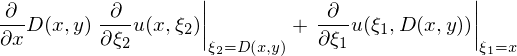

In [76]:
x, y, u, D = symbols('x, y, u, D')
diff(u(x, D(x,y)), x)

In [77]:
# G_2_dx = B_dx
z, x, y, w, D, u, D_dx = symbols('z, x, y, w, D, u, D_dx')

# Term for B as a function of x, y, D and u.
beta_1 =z*(6*x-2+x*z)/(4*x)+(1+z)*ln((1+y)/(1+z))-ln(1+z)/2+ln(1+x*z)/(2*x**2)
beta_2 =(2*(1+x)*(1+w)*(z+w**2)+3*(w-z))/(2*(1+w)**2)-1/(2*x)*ln(1+x*z+x*w+x*w**2)+(1-4*x)/(2*x)*ln(1+w)+(1-4*x+2*x**2)/(4*x)*ln((1-x+x*z-x*w+x*w**2)/((1-x)*(z+w**2+1+w)))
B = (x**2/2*beta_1-x/4*beta_2).subs(z,D).subs(w,D*(1+u))

# Treat D as a function.
B = B.subs(D, D(x,y))
# Here we treat D as a symbol rather than a function to prevent sympy from doing crazy things we don't want.
B = B.subs(u, u(x,D))
# Note that there is no v in the expression for B.
# Derive B with respect to x.
B_dx = diff(B, x)
# Apply the chain rule - we need the explicit terms of u_dx, u_dy for that. D_dx is just a symbol.
u_dy = -x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
u_dx = -y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
B_dx = B_dx.subs(
    Derivative(u(x, D), x),
    D_dx*u_dy.subs(y, D) + u_dx.subs(y, D)
)
# Replace other occurrences of derivative of D by symbol D_dx.
B_dx = B_dx.subs(Derivative(D(x,y), x), D_dx)
# Replace previuosly introduced functions by symbols again.
B_dx = B_dx.subs(u(x,D), u).subs(D(x,y), D)
# Simplification takes looong and does not give much (I tried).
#B_dx = simplify(B_dx)
# The result is a function of u,v,x,y,D,D_x
print(B_dx)

x**2*(D*(D + D_dx*x + 6)/(4*x) - D*(D*x + 6*x - 2)/(4*x**2) + D_dx*log((y + 1)/(D + 1)) - D_dx - D_dx/(2*(D + 1)) + D_dx*(D*x + 6*x - 2)/(4*x) + (D + D_dx*x)/(2*x**2*(D*x + 1)) - log(D*x + 1)/x**3)/2 + x*(D*(D*x + 6*x - 2)/(4*x) + (D + 1)*log((y + 1)/(D + 1)) - log(D + 1)/2 + log(D*x + 1)/(2*x**2)) - x*((3*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 3*D_dx*(u + 1) - 3*D_dx + (2*x + 2)*(D*(u + 1) + 1)*(2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx*(u + 1)**2 + D_dx) + (2*x + 2)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))*(D**2*(u + 1)**2 + D) + 2

In [78]:
def eval_G_2_dx(x,y):
    D, _, _, _, u, v = eval_D_S_P_H_u_v(x, y)
    D_dx, _, _, _ = eval_D_dx_S_dx_P_dx_H_dx(x, y)
    B_dx = x**2*(D*(D + D_dx*x + 6)/(4*x) - D*(D*x + 6*x - 2)/(4*x**2) + D_dx*log((y + 1)/(D + 1)) - D_dx - D_dx/(2*(D + 1)) + D_dx*(D*x + 6*x - 2)/(4*x) + (D + D_dx*x)/(2*x**2*(D*x + 1)) - log(D*x + 1)/x**3)/2 + x*(D*(D*x + 6*x - 2)/(4*x) + (D + 1)*log((y + 1)/(D + 1)) - log(D + 1)/2 + log(D*x + 1)/(2*x**2)) - x*((3*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 3*D_dx*(u + 1) - 3*D_dx + (2*x + 2)*(D*(u + 1) + 1)*(2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx*(u + 1)**2 + D_dx) + (2*x + 2)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))*(D**2*(u + 1)**2 + D) + 2*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(2*(D*(u + 1) + 1)**2) + (-2*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D_dx*(u + 1))*(3*D*(u + 1) - 3*D + (2*x + 2)*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(2*(D*(u + 1) + 1)**3) + (-4*x + 1)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))/(2*x*(D*(u + 1) + 1)) + (-x + 1)*(2*x**2 - 4*x + 1)*((2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D*(u + 1) + D - D_dx*x*(u + 1) + D_dx*x - 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)*(-2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx*(u + 1)**2 - D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1) - D_dx)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**2) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)**2*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)/(4*x*(D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)) + (4*x - 4)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(4*x) - 2*log(D*(u + 1) + 1)/x - (2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 + D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D*(u + 1) + D + D_dx*x*(u + 1) + D_dx*x)/(2*x*(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)) - (-4*x + 1)*log(D*(u + 1) + 1)/(2*x**2) - (2*x**2 - 4*x + 1)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(4*x**2) + log(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)/(2*x**2))/4 - (3*D*(u + 1) - 3*D + (2*x + 2)*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(8*(D*(u + 1) + 1)**2) - (-4*x + 1)*log(D*(u + 1) + 1)/(8*x) - (2*x**2 - 4*x + 1)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(16*x) + log(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)/(8*x)
    return B_dx

In [79]:
compare('G_2_dx', 'x*G_1_dx(x,y)', 'y', eval_G_2_dx)

1.27078980963512829733177061851493625727e-13


### $\frac{\partial^2}{\partial x^2}G_2 = G_2''$ (G_2_dx_dx)

Similar as before we have to apply chain rule but this time with a higher order derivative:

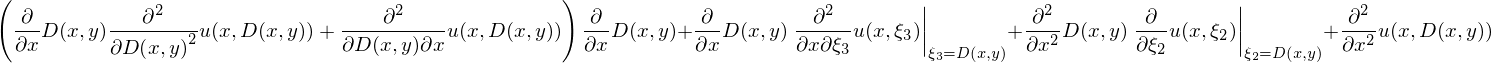

In [80]:
x, y, u, D = symbols('x, y, u, D')
diff(u(x,D(x,y)), x, x)

In [81]:
# B_dx_dx = G_2_dx_dx
z, x, y, w, D, u, D_dx, D_dx_dx = symbols('z, x, y, w, D, u, D_dx, D_dx_dx')

# Term for B as a function of x, y, D and u.
beta_1 =z*(6*x-2+x*z)/(4*x)+(1+z)*ln((1+y)/(1+z))-ln(1+z)/2+ln(1+x*z)/(2*x**2)
beta_2 =(2*(1+x)*(1+w)*(z+w**2)+3*(w-z))/(2*(1+w)**2)-1/(2*x)*ln(1+x*z+x*w+x*w**2)+(1-4*x)/(2*x)*ln(1+w)+(1-4*x+2*x**2)/(4*x)*ln((1-x+x*z-x*w+x*w**2)/((1-x)*(z+w**2+1+w)))
B = (x**2/2*beta_1-x/4*beta_2).subs(z,D).subs(w,D*(1+u))
B = B.subs(D, D(x,y)).subs(u, u(x,D)) # there is no v in the expression

B_dx = x**2*(D*(D + D_dx*x + 6)/(4*x) - D*(D*x + 6*x - 2)/(4*x**2) + D_dx*log((y + 1)/(D + 1)) - D_dx - D_dx/(2*(D + 1)) + D_dx*(D*x + 6*x - 2)/(4*x) + (D + D_dx*x)/(2*x**2*(D*x + 1)) - log(D*x + 1)/x**3)/2 + x*(D*(D*x + 6*x - 2)/(4*x) + (D + 1)*log((y + 1)/(D + 1)) - log(D + 1)/2 + log(D*x + 1)/(2*x**2)) - x*((3*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 3*D_dx*(u + 1) - 3*D_dx + (2*x + 2)*(D*(u + 1) + 1)*(2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx*(u + 1)**2 + D_dx) + (2*x + 2)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))*(D**2*(u + 1)**2 + D) + 2*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(2*(D*(u + 1) + 1)**2) + (-2*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D_dx*(u + 1))*(3*D*(u + 1) - 3*D + (2*x + 2)*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(2*(D*(u + 1) + 1)**3) + (-4*x + 1)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))/(2*x*(D*(u + 1) + 1)) + (-x + 1)*(2*x**2 - 4*x + 1)*((2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D*(u + 1) + D - D_dx*x*(u + 1) + D_dx*x - 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)*(-2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx*(u + 1)**2 - D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1) - D_dx)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**2) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)**2*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)/(4*x*(D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)) + (4*x - 4)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(4*x) - 2*log(D*(u + 1) + 1)/x - (2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 + D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D*(u + 1) + D + D_dx*x*(u + 1) + D_dx*x)/(2*x*(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)) - (-4*x + 1)*log(D*(u + 1) + 1)/(2*x**2) - (2*x**2 - 4*x + 1)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(4*x**2) + log(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)/(2*x**2))/4 - (3*D*(u + 1) - 3*D + (2*x + 2)*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(8*(D*(u + 1) + 1)**2) - (-4*x + 1)*log(D*(u + 1) + 1)/(8*x) - (2*x**2 - 4*x + 1)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(16*x) + log(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)/(8*x)
B_dx = B_dx.subs(D, D(x,y)).subs(D_dx, D_dx(x,y)).subs(u, u(x,D)).subs(v, v(x,D))

B_dx_dx = diff(B_dx, x)

# substitute Derivative(u(x, D), x)
u_dx = -y*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
u_dy = -x*(v + 1)*(2*u**2*y + 4*u*y + v + 2*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
B_dx_dx = B_dx_dx.subs(
    Derivative(u(x, D), x),
    D_dx * u_dy.subs(y, D) + u_dx.subs(y, D)
)
# substitute Derivative(u(x, D), x)
v_dx = -2*y**2*(u + 1)*(v + 1)**2/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
v_dy = -(u + 1)*(u + 2*v**2*x*y + 4*v*x*y + 2*x*y + 1)/(4*u*v*x*y**2 + 4*u*x*y**2 + 4*v*x*y**2 + 4*x*y**2 - 1)
B_dx_dx = B_dx_dx.subs(
    Derivative(v(x, D), x),
    D_dx * v_dy.subs(y, D) + v_dx.subs(y, D)
)
# substitute Derivative(D(x, y), x) by symbol D_dx
B_dx_dx = B_dx_dx.subs(Derivative(D(x,y), x), D_dx)
# substitute Derivative(D_dx(x, y), x) by symbol D_dx_dx
B_dx_dx = B_dx_dx.subs(Derivative(D_dx(x,y), x), D_dx_dx)
# resubstitute functions by symbols
B_dx_dx = B_dx_dx.subs(u(x,D), u).subs(v(x,D), v).subs(D(x,y), D).subs(D_dx(x,y), D_dx)

print(B_dx_dx)

D*(D*x + 6*x - 2)/(4*x) + x**2*(D*(2*D_dx + D_dx_dx*x)/(4*x) - D*(D + D_dx*x + 6)/(2*x**2) + D*(D*x + 6*x - 2)/(2*x**3) + 2*D_dx**2/(2*D + 2)**2 - D_dx**2/(D + 1) + D_dx*(D + D_dx*x + 6)/(2*x) - D_dx*(D*x + 6*x - 2)/(2*x**2) + D_dx_dx*log((y + 1)/(D + 1)) - D_dx_dx - D_dx_dx/(2*D + 2) + D_dx_dx*(D*x + 6*x - 2)/(4*x) + (-D - D_dx*x)*(D + D_dx*x)/(2*x**2*(D*x + 1)**2) + (2*D_dx + D_dx_dx*x)/(2*x**2*(D*x + 1)) - 2*(D + D_dx*x)/(x**3*(D*x + 1)) + 3*log(D*x + 1)/x**4)/2 + x*(D*(D + D_dx*x + 6)/(4*x) - D*(D*x + 6*x - 2)/(4*x**2) + D_dx*log((y + 1)/(D + 1)) - D_dx - D_dx/(2*(D + 1)) + D_dx*(D*x + 6*x - 2)/(4*x) + (D + D_dx*x)/(2*x**2*(D*x + 1)) - log(D*x + 1)/x**3) + x*(D*(D + D_dx*x + 6)/(4*x) - D*(D*x + 6*x - 2)/(4*x**2) + D_dx*log((y + 1)/(D + 1)) - D_dx - D_dx/(2*D + 2) + D_dx*(D*x + 6*x - 2)/(4*x) + (D + D_dx*x)/(2*x**2*(D*x + 1)) - log(D*x + 1)/x**3) - x*((3*D*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D

In [82]:
def eval_G_2_dx_dx(x,y):
    D, _, _, _, u, v = eval_D_S_P_H_u_v(x, y)
    D_dx, _, _, _ = eval_D_dx_S_dx_P_dx_H_dx(x, y)
    D_dx_dx, _, _, _ = eval_D_dx_dx_S_dx_dx_P_dx_dx_H_dx_dx(x, y)
    B_dx_dx = D*(D*x + 6*x - 2)/(4*x) + x**2*(D*(2*D_dx + D_dx_dx*x)/(4*x) - D*(D + D_dx*x + 6)/(2*x**2) + D*(D*x + 6*x - 2)/(2*x**3) + 2*D_dx**2/(2*D + 2)**2 - D_dx**2/(D + 1) + D_dx*(D + D_dx*x + 6)/(2*x) - D_dx*(D*x + 6*x - 2)/(2*x**2) + D_dx_dx*log((y + 1)/(D + 1)) - D_dx_dx - D_dx_dx/(2*D + 2) + D_dx_dx*(D*x + 6*x - 2)/(4*x) + (-D - D_dx*x)*(D + D_dx*x)/(2*x**2*(D*x + 1)**2) + (2*D_dx + D_dx_dx*x)/(2*x**2*(D*x + 1)) - 2*(D + D_dx*x)/(x**3*(D*x + 1)) + 3*log(D*x + 1)/x**4)/2 + x*(D*(D + D_dx*x + 6)/(4*x) - D*(D*x + 6*x - 2)/(4*x**2) + D_dx*log((y + 1)/(D + 1)) - D_dx - D_dx/(2*(D + 1)) + D_dx*(D*x + 6*x - 2)/(4*x) + (D + D_dx*x)/(2*x**2*(D*x + 1)) - log(D*x + 1)/x**3) + x*(D*(D + D_dx*x + 6)/(4*x) - D*(D*x + 6*x - 2)/(4*x**2) + D_dx*log((y + 1)/(D + 1)) - D_dx - D_dx/(2*D + 2) + D_dx*(D*x + 6*x - 2)/(4*x) + (D + D_dx*x)/(2*x**2*(D*x + 1)) - log(D*x + 1)/x**3) - x*((3*D*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - 2*D*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - D_dx*x*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 4*D*u*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*u**2 + 4*D_dx*u + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 2*D_dx)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 6*D_dx*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 3*D_dx_dx*(u + 1) - 3*D_dx_dx + (2*x + 2)*(D*(u + 1) + 1)*(2*D**2*(u + 1)*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - 2*D*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - D_dx*x*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 4*D*u*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*u**2 + 4*D_dx*u + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 2*D_dx)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D**2*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))**2 + 8*D*D_dx*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx_dx*(u + 1)**2 + 2*D_dx**2*(u + 1)**2 + D_dx_dx) + 2*(2*x + 2)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))*(2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx*(u + 1)**2 + D_dx) + (2*x + 2)*(D**2*(u + 1)**2 + D)*(D*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - 2*D*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - D_dx*x*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 4*D*u*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*u**2 + 4*D_dx*u + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 2*D_dx)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx_dx*(u + 1)) + 2*(D*(u + 1) + 1)*(2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx*(u + 1)**2 + D_dx) + (2*D*(u + 1) + 2)*(2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx*(u + 1)**2 + D_dx) + 2*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))*(D**2*(u + 1)**2 + D) + (2*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*(u + 1))*(D**2*(u + 1)**2 + D))/(2*(D*(u + 1) + 1)**2) + (-2*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D_dx*(u + 1))*(3*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 3*D_dx*(u + 1) - 3*D_dx + (2*x + 2)*(D*(u + 1) + 1)*(2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx*(u + 1)**2 + D_dx) + (2*x + 2)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))*(D**2*(u + 1)**2 + D) + 2*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(2*(D*(u + 1) + 1)**3) + (-2*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D_dx*(u + 1))*(3*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 3*D_dx*(u + 1) - 3*D_dx + (2*x + 2)*(D*(u + 1) + 1)*(2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx*(u + 1)**2 + D_dx) + (2*x + 2)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))*(D**2*(u + 1)**2 + D) + (2*D*(u + 1) + 2)*(D**2*(u + 1)**2 + D))/(2*(D*(u + 1) + 1)**3) + (3*D*(u + 1) - 3*D + (2*x + 2)*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))*(-2*D*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - 2*D*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - D_dx*x*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 4*D*u*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*u**2 + 4*D_dx*u + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 2*D_dx)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D_dx*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D_dx_dx*(u + 1))/(2*(D*(u + 1) + 1)**3) + (-3*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 3*D_dx*(u + 1))*(-2*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D_dx*(u + 1))*(3*D*(u + 1) - 3*D + (2*x + 2)*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(2*(D*(u + 1) + 1)**4) + (-4*x + 1)*(D*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - 2*D*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - D_dx*x*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 4*D*u*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*u**2 + 4*D_dx*u + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 2*D_dx)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx_dx*(u + 1))/(2*x*(D*(u + 1) + 1)) + (-4*x + 1)*(-D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1))*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))/(2*x*(D*(u + 1) + 1)**2) + (-x + 1)*(4*x - 4)*((2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D*(u + 1) + D - D_dx*x*(u + 1) + D_dx*x - 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)*(-2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx*(u + 1)**2 - D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1) - D_dx)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**2) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)**2*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)/(2*x*(D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)) + (-x + 1)*(2*x**2 - 4*x + 1)*((2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D*(u + 1) + D - D_dx*x*(u + 1) + D_dx*x - 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)*(-2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx*(u + 1)**2 - D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1) - D_dx)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**2) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)**2*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)*(-2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D**2*(u + 1)**2 - 2*D*D_dx*x*(u + 1)**2 + D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D*(u + 1) - D + D_dx*x*(u + 1) - D_dx*x + 1)/(4*x*(D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)**2) + (-x + 1)*(2*x**2 - 4*x + 1)*((2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D*(u + 1) + D - D_dx*x*(u + 1) + D_dx*x - 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)*(-2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx*(u + 1)**2 - D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1) - D_dx)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**2) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)**2*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))*(2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx*(u + 1)**2 + D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1) + D_dx)/(4*x*(D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)) + (-x + 1)*(2*x**2 - 4*x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)*((2*D**2*x*(u + 1)*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - 2*D*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - D_dx*x*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 4*D*u*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*u**2 + 4*D_dx*u + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 2*D_dx)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))**2 + 4*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 8*D*D_dx*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*D_dx*(u + 1)**2 + 2*D*D_dx_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - 2*D*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - D_dx*x*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 4*D*u*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*u**2 + 4*D_dx*u + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 2*D_dx)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx**2*x*(u + 1)**2 - 2*D_dx*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D_dx*(u + 1) + 2*D_dx - D_dx_dx*x*(u + 1) + D_dx_dx*x)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)*(-2*D**2*(u + 1)*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - 2*D*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - D_dx*x*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 4*D*u*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*u**2 + 4*D_dx*u + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 2*D_dx)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D**2*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))**2 - 8*D*D_dx*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx_dx*(u + 1)**2 - D*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - 2*D*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - D_dx*x*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 4*D*u*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*u**2 + 4*D_dx*u + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 2*D_dx)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D_dx**2*(u + 1)**2 - 2*D_dx*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx_dx*(u + 1) - D_dx_dx)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**2) + 2*(-2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx*(u + 1)**2 - D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1) - D_dx)*(2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D*(u + 1) + D - D_dx*x*(u + 1) + D_dx*x - 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**2) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)*(-4*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D*D_dx*(u + 1)**2 - 2*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D_dx*(u + 1) - 2*D_dx)*(-2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx*(u + 1)**2 - D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1) - D_dx)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**3) + 2*(2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D*(u + 1) + D - D_dx*x*(u + 1) + D_dx*x - 1)/((-x + 1)**2*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)) + 2*(D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)*(-2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx*(u + 1)**2 - D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1) - D_dx)/((-x + 1)**2*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**2) + 2*(D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)**3*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(4*x*(D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)) - (2*x**2 - 4*x + 1)*((2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D*(u + 1) + D - D_dx*x*(u + 1) + D_dx*x - 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)*(-2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx*(u + 1)**2 - D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1) - D_dx)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**2) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)**2*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)/(4*x*(D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)) + log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/x - (2*D**2*x*(u + 1)*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - 2*D*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - D_dx*x*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 4*D*u*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*u**2 + 4*D_dx*u + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 2*D_dx)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))**2 + 4*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 8*D*D_dx*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*D_dx*(u + 1)**2 + 2*D*D_dx_dx*x*(u + 1)**2 + D*x*(-D*(v + 1)**2*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - 2*D*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)*(-4*D**2*u*v - 4*D**2*u*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*u - 4*D**2*v*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*v - 4*D**2*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 4*D**2 - 8*D*D_dx*u*v*x - 8*D*D_dx*u*x - 8*D*D_dx*v*x - 8*D*D_dx*x)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)**2 - D_dx*x*(v + 1)*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 4*D*u*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 4*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*u**2 + 4*D_dx*u + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + 2*D_dx)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(-2*D**2*(u + 1)*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) + D_dx*(-u - 1)*(2*D*v**2*x + 4*D*v*x + 2*D*x + u + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1))*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx**2*x*(u + 1)**2 + 2*D_dx*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D_dx*(u + 1) + 2*D_dx + D_dx_dx*x*(u + 1) + D_dx_dx*x)/(2*x*(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)) - (-2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D**2*(u + 1)**2 - 2*D*D_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D*(u + 1) - D - D_dx*x*(u + 1) - D_dx*x)*(2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 + D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D*(u + 1) + D + D_dx*x*(u + 1) + D_dx*x)/(2*x*(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)**2) - 4*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))/(x*(D*(u + 1) + 1)) - (-4*x + 1)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))/(x**2*(D*(u + 1) + 1)) - (-x + 1)*(2*x**2 - 4*x + 1)*((2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D*(u + 1) + D - D_dx*x*(u + 1) + D_dx*x - 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)*(-2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx*(u + 1)**2 - D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1) - D_dx)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**2) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)**2*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)/(2*x**2*(D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)) - (4*x - 4)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(2*x**2) + 4*log(D*(u + 1) + 1)/x**2 + (2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 + D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D*(u + 1) + D + D_dx*x*(u + 1) + D_dx*x)/(x**2*(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)) + (-4*x + 1)*log(D*(u + 1) + 1)/x**3 + (2*x**2 - 4*x + 1)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(2*x**3) - log(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)/x**3)/4 + (D + 1)*log((y + 1)/(D + 1)) - log(D + 1)/2 - (3*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 3*D_dx*(u + 1) - 3*D_dx + (2*x + 2)*(D*(u + 1) + 1)*(2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx*(u + 1)**2 + D_dx) + (2*x + 2)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))*(D**2*(u + 1)**2 + D) + 2*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(8*(D*(u + 1) + 1)**2) - (3*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 3*D_dx*(u + 1) - 3*D_dx + (2*x + 2)*(D*(u + 1) + 1)*(2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + 2*D*D_dx*(u + 1)**2 + D_dx) + (2*x + 2)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))*(D**2*(u + 1)**2 + D) + (2*D*(u + 1) + 2)*(D**2*(u + 1)**2 + D))/(8*(D*(u + 1) + 1)**2) - (-2*D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D_dx*(u + 1))*(3*D*(u + 1) - 3*D + (2*x + 2)*(D*(u + 1) + 1)*(D**2*(u + 1)**2 + D))/(4*(D*(u + 1) + 1)**3) - (-4*x + 1)*(D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D_dx*(u + 1))/(4*x*(D*(u + 1) + 1)) - (-x + 1)*(2*x**2 - 4*x + 1)*((2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 - D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D*(u + 1) + D - D_dx*x*(u + 1) + D_dx*x - 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)*(-2*D**2*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - 2*D*D_dx*(u + 1)**2 - D*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) - D_dx*(u + 1) - D_dx)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)**2) + (D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)**2*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)/(8*x*(D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)) - (4*x - 4)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(8*x) + log(D*(u + 1) + 1)/x + (2*D**2*x*(u + 1)*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D**2*(u + 1)**2 + 2*D*D_dx*x*(u + 1)**2 + D*x*(-D*(v + 1)**2/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1) - D_dx*x*(v + 1)*(2*D*u**2 + 4*D*u + 2*D + v + 1)/(4*D**2*u*v*x + 4*D**2*u*x + 4*D**2*v*x + 4*D**2*x - 1)) + D*(u + 1) + D + D_dx*x*(u + 1) + D_dx*x)/(4*x*(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)) + (-4*x + 1)*log(D*(u + 1) + 1)/(4*x**2) + (2*x**2 - 4*x + 1)*log((D**2*x*(u + 1)**2 - D*x*(u + 1) + D*x - x + 1)/((-x + 1)*(D**2*(u + 1)**2 + D*(u + 1) + D + 1)))/(8*x**2) + log(D*x + 1)/(2*x**2) - log(D**2*x*(u + 1)**2 + D*x*(u + 1) + D*x + 1)/(4*x**2)
    return B_dx_dx

In [83]:
compare('G_2_dx_dx', 'x*G_1_dx(x,y)', 'y', eval_G_2_dx_dx)

0.000000001210101398536735431961367700594452445154


## Connected planar graphs

### $F = x\frac{\partial}{\partial x}G_1$ (vertex pointed l-derived connected planar graph, we stick to Fusy's notation here)

We implement our own shitty root finding just using bisection ... (we could do better but who cares)

In [130]:
def eval_F(z, y):
    def inverse_F(x,y):
        return x * mp.exp(-eval_G_2_dx(x,y))
    left = 0.0
    right = 1.0
    max_steps = 50
    for _ in range(max_steps):
        x = 1/2 * (left + right)
        try:
            value = inverse_F(x, y) - z
            if value < 0:
                # we were too small
                left = x
            else:
                # we were too large
                right = x
        except:
            # we were too large
            right = x
    return x

def eval_F_newton(z, y):
    def inverse_F(x,y):
        return x * mp.exp(-eval_G_2_dx(x,y))
    def inverse_F_dx(x,y):
        return mp.exp(-eval_G_2_dx(x,y)) - x * eval_G_2_dx_dx(x,y) * mp.exp(-eval_G_2_dx(x,y))
    x = 0.001
    for _ in range(10):
        x = x - (inverse_F(x, y) - z) / inverse_F_dx(x,y)
        print(x)

In [131]:
compare('x*G_1_dx(x,y)', 'x', 'y', eval_F_newton)

0.03679917470439002660799446289262658824675
0.03818699151756331277315046707118696340225
0.03818910818721755585690128382978211882335
0.03818910819329967919071543617410110616709
0.03818910819329967919076839954316654666104
0.03818910819329967919076839954316654666107
0.03818910819329967919076839954316654666104
0.03818910819329967919076839954316654666089
0.03818910819329967919076839954316654666105
0.03818910819329967919076839954316654666095


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [85]:
compare('x*G_1_dx(x,y)', 'x', 'y', eval_F)

D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.0


### $G_1$ (aka C)

In [86]:
def eval_G_1(x,y,F=None):
    if F is None:
        F = eval_F(x,y)
    G_1 = F * mp.log(x) - F * mp.log(F) + F + eval_G_2(F, y)
    return G_1

In [87]:
compare('G_1(x,y)', 'x', 'y', eval_G_1)

D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


9.722001813169841359012936808891162015141e-17


### $\frac{\partial}{\partial x}G_1$ (G_1_dx aka dC)

In [88]:
def eval_G_1_dx(x,y,F=None):
    if F is None:
        F = eval_F(x,y)
    return F/x

In [89]:
compare('G_1_dx(x,y)', 'x', 'y', eval_G_1_dx)

D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.0


### $\frac{\partial^2}{\partial x^2}G_1$ (G_1_dx_dx aka ddC)

In [90]:
def eval_G_1_dx_dx(x,y,F=None):
    def inverse_F_dx(x,y):
        G_2_dx = eval_G_2_dx(x,y)
        G_2_dx_dx = eval_G_2_dx_dx(x,y)
        return mp.exp(-G_2_dx) * (1 - x*G_2_dx_dx)
    if F is None:
        F = eval_F(x,y)
    F_dx = 1/inverse_F_dx(F, y)
    G_1_dx_dx = -F/x**2 + F_dx/x
    return G_1_dx_dx

In [91]:
compare('G_1_dx_dx(x,y)', 'x', 'y', eval_G_1_dx_dx)

D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.000000001260870183050580079160916376391674274874


### $G$

In [92]:
def eval_G(x,y, F=None):
    G_1 = eval_G_1(x,y,F)
    return mp.exp(G_1)

In [93]:
compare('G', 'x', 'y', eval_G)

D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


3.928711099965774359766796978608100805027e-17


### $\frac{\partial}{\partial x}G$ (G_dx aka dG)

In [94]:
def eval_G_dx(x,y, F=None):
    G_1_dx = eval_G_1_dx(x,y,F)
    G = eval_G(x,y,F)
    return G_1_dx * G

In [95]:
compare('G_dx', 'x', 'y', eval_G_dx)

D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


1.697191924910298343294355092429212496065e-16


### $\frac{\partial^2}{\partial x^2}G$ (G_dx_dx aka ddG)

In [116]:
def eval_G_dx_dx(x,y, F=None):
    G_1_dx_dx = eval_G_1_dx_dx(x,y,F)
    G = eval_G(x,y,F)
    G_1_dx = eval_G_1_dx(x,y,F)
    G_dx = eval_G_dx(x,y,F)
    return G_1_dx_dx*G + G_dx*G_1_dx

In [97]:
# Takes very long.
#compare('G_dx_dx', 'x', 'y', eval_G_dx_dx)

In [117]:
x = mpf('0.0367265761612091283824619433531762063743')
y = 1.0
F = eval_F(x,y)
eval_G_dx_dx(x,y,F)

D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


mpf('2.352622919488844753896167354422442693834169')

test test ...


In [105]:
from scipy.misc import derivative

In [123]:


def eval_G_dx_dx_dx(x,y):
    #F = eval_F(x,y)
    func = lambda x: eval_G_dx_dx(x,y,eval_F(x,y))
    return derivative(func, x)
    epsilon = mpf('0.001')
    a = func(x + epsilon)
    b = func(x)
    print(a)
    print(b)
    delta = a - b
    return delta/epsilon

In [124]:
compare('G_dx_dx_dx', 'x', 'y', eval_G_dx_dx_dx)

D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.9848724708299156226929257185084101168883


### A combination of G_1 and G and their derivatives for efficiency

In [98]:
def eval_G_1_G_1_dx_G_1_dx_dx(x,y):
    F = eval_F(x,y)
    return eval_G_1(x,y,F), eval_G_1_dx(x,y,F), eval_G_1_dx_dx(x,y,F)

In [99]:
compare(['G_1', 'G_1_dx', 'G_1_dx_dx'], 'x', 'y', eval_G_1_G_1_dx_G_1_dx_dx)

D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
D:\anaconda\envs\networkx36\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


9.722001813169841359012936808891162015141e-17
0.0
0.000000001260870183050580079160916376391674274874
